In [319]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
import copy
import random
import os

In [323]:
ore_data_list = [
    (15, 130848), (17, 128592), (19, 157920), (21, 180480), (23, 254928), (25, 275232),
    (27, 348160), (29, 564000), (31, 789600), (33, 726432), (35, 815200), (37, 880960),
    (39, 858800), (41, 820400), (43, 757280), (45, 630848), (47, 557920), (49, 380480),
    (51, 210880), (53, 238400), (55, 104560), (57, 106080), (59, 82000)
]

# Create a dictionary for ore data (grade: tonnage)
ore_data = {grade: ton for grade, ton in ore_data_list}

# Function to perform random selection from ore data
def random_selection(ore_data, required_ton):
    selected_ores = []
    remaining_ton = required_ton

    while remaining_ton > 0 and ore_data:
        possible_grades = [grade for grade in ore_data if ore_data[grade] > 0]
        if not possible_grades:
            break
        grade = random.choice(possible_grades)
        ore_ton = ore_data[grade]
        tonnage_to_use = min(remaining_ton, ore_ton)

        if tonnage_to_use > 0:
            selected_ores.append((grade, tonnage_to_use))
            remaining_ton -= tonnage_to_use
            ore_data[grade] -= tonnage_to_use
            if ore_data[grade] == 0:
                del ore_data[grade]

    return selected_ores

# Function to calculate average grade from selected ores
def calculate_average_grade(selected_ores):
    total_ton = sum(ton for grade, ton in selected_ores)
    weighted_sum = sum(grade * ton for grade, ton in selected_ores)
    return weighted_sum / total_ton if total_ton else 0

# Function to calculate yield based on grade
def calculate_yield(grade):
    return (-0.0004 * (grade ** 3)) + (0.0461 * (grade ** 2)) - (0.1765 * grade) + 0.72

# Function to calculate product amount based on annual ton and average grade
def calculate_product(annual_ton, average_grade):
    yield_value = calculate_yield(average_grade) / 100
    product = annual_ton * yield_value
    return product

# Function to calculate cost based on grade
def calculate_cost(grade):
    return 0.1 * grade + 3.7

# Function to calculate mining cost based on annual production
def calculate_mining_cost(annual_production):
    return (((-0.1 * (annual_production / 100000)) + 8.5) * annual_production)

# Function to calculate revenue based on product amounts and ore prices
def calculate_revenue(product_amounts, ore_prices):
    revenue_results = []
    total_revenue = 0
    for i, (year, annual_production_ton, avg_grade, yield_percentage, product_amount, _, _) in enumerate(product_amounts):
        price = ore_prices[i % len(ore_prices)]
        revenue = product_amount * price
        total_revenue += revenue
        revenue_results.append((year, round(avg_grade, 1), round(yield_percentage, 1), int(product_amount), int(revenue)))
    return revenue_results, total_revenue

# Function to calculate new investment cost
def calculate_new_investment_cost(existing_cost, existing_capacity, initial_annual_production_ton, factor=0.6):
    new_cost = existing_cost * (initial_annual_production_ton / existing_capacity) ** factor
    return new_cost

# Function to calculate annual payment for a loan
def calculate_annual_payment(principal, annual_interest_rate, years):
    r = annual_interest_rate / 100
    n = years
    annual_payment = (principal * r) / (1 - (1 + r) ** -n)
    return annual_payment

# Function to calculate NPV for a given production tonnage
def calculate_npv_for_production_ton(initial_annual_production_ton):
    ore_data_copy = copy.deepcopy(ore_data)
    total_ton = sum(ore_data_copy.values())
    years_of_production = total_ton // initial_annual_production_ton
    last_year_production_ton = total_ton % initial_annual_production_ton
    results = []

    for year in range(1, years_of_production + 2):
        if year == years_of_production + 1 and last_year_production_ton != 0:
            annual_production_ton = last_year_production_ton
        else:
            annual_production_ton = initial_annual_production_ton

        selected_ores = random_selection(ore_data_copy, annual_production_ton)
        average_grade = calculate_average_grade(selected_ores)
        if selected_ores:
            results.append((year, annual_production_ton, round(average_grade, 1)))

    product_results = []

    for year, annual_production_ton, average_grade in results:
        yield_value = calculate_yield(average_grade) / 100
        product = calculate_product(annual_production_ton, average_grade)
        p_cost = calculate_cost(average_grade) * product
        mining_cost = calculate_mining_cost(annual_production_ton)
        product_results.append((year, annual_production_ton, round(average_grade, 1), round(yield_value * 100, 1), int(product), int(p_cost), int(mining_cost)))

    ore_prices = [70, 75, 82, 88, 96, 112, 125, 120, 118, 115, 120, 92, 110, 88, 115, 100, 110, 92, 90, 118]
    revenue_results, total_revenue = calculate_revenue(product_results, ore_prices)

    existing_investment_cost = 10000000
    existing_capacity = 500000
    new_investment_cost = calculate_new_investment_cost(existing_investment_cost, existing_capacity, initial_annual_production_ton)

    principal = new_investment_cost
    annual_interest_rate = 5
    years = 4
    annual_payment = calculate_annual_payment(new_investment_cost, annual_interest_rate, years)

    processing_costs = [p_cost for _, _, _, _, _, p_cost, _ in product_results]
    mining_costs = [m_cost for _, _, _, _, _, _, m_cost in product_results]
    waste_rock_costs = [15000000 / len(product_results)] * len(product_results)

    net_income_results = []
    for i, (year, avg_grade, yield_percentage, product_amount, revenue) in enumerate(revenue_results):
        net_income = revenue - annual_payment - processing_costs[i] - mining_costs[i] - waste_rock_costs[i] if i < 4 else revenue - processing_costs[i] - mining_costs[i] - waste_rock_costs[i]
        net_income_results.append((year, avg_grade, yield_percentage, product_amount, revenue, int(net_income)))

    npv = 0
    discount_rate = 0.1

    for i in range(len(net_income_results)):
        discounted_net_income = net_income_results[i][5]
        npv += discounted_net_income / (1 + discount_rate) ** (i + 1)

    net_present_value = npv - new_investment_cost
    return net_present_value

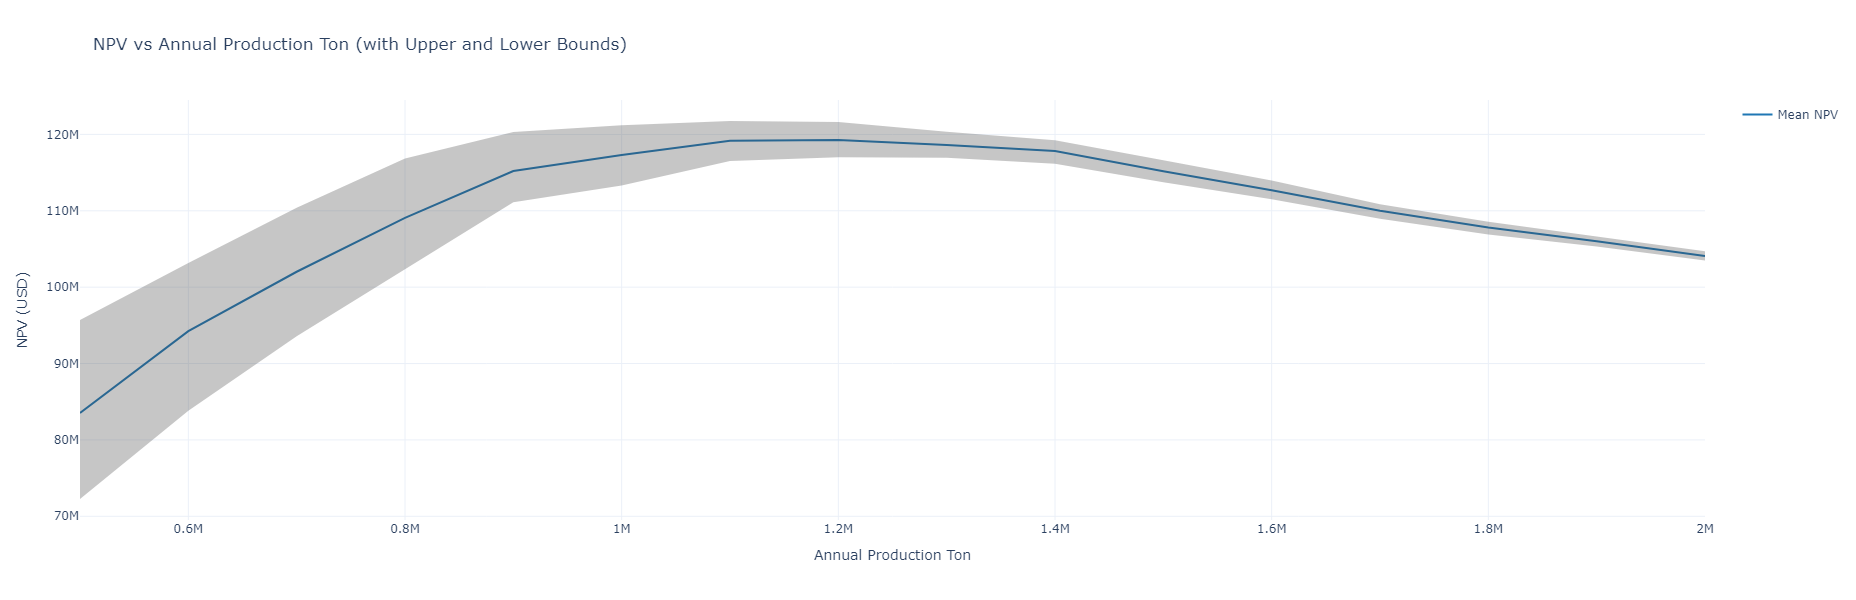

In [324]:
# Production ton values and NPV trials initialization
production_ton_values = range(500000, 2000001, 100000)
npv_trials = {ton: [] for ton in production_ton_values}

num_trials = 1000

# Conduct multiple trials for each production ton value
for annual_production_ton in production_ton_values:
    for _ in range(num_trials):
        npv = calculate_npv_for_production_ton(annual_production_ton)
        npv_trials[annual_production_ton].append(npv)

# Calculate min, max, and mean NPV for each production ton value
npv_stats = {
    ton: (np.min(npv_trials[ton]), np.max(npv_trials[ton]), np.mean(npv_trials[ton]))
    for ton in production_ton_values
}

# Prepare data for visualization
ton_values = list(npv_stats.keys())
min_npv = [npv_stats[ton][0] for ton in ton_values]
max_npv = [npv_stats[ton][1] for ton in ton_values]
mean_npv = [npv_stats[ton][2] for ton in ton_values]

# Visualize the results with upper and lower bounds
fig = go.Figure([
    go.Scatter(
        name='Mean NPV',
        x=ton_values,
        y=mean_npv,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=ton_values,
        y=max_npv,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=ton_values,
        y=min_npv,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])

fig.update_layout(
    title='NPV vs Annual Production Ton (with Upper and Lower Bounds)',
    xaxis_title='Annual Production Ton',
    yaxis_title='NPV (USD)',
    template='plotly_white',
    width=1800,
    height=600
)

fig.show()